In [1]:
# 簡單的mnist訓練測試
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255  # 影像正則化
X_test = X_test.astype('float32') / 255 # 影像正則化

Using TensorFlow backend.


In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
features_train, features_test, targets_train, targets_test = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 42) # trainset與testset數據分集
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

In [5]:
# Pytorch train and test TensorDataset
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

In [6]:
# Hyper Parameters 超參數
# batch_size, epoch and iteration
LR = 0.01
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)
# num_epochs = 5

In [7]:
# Pytorch DataLoader 影像傳入model前的準備，batch size
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [8]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1 , input_shape=(1,28,28)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0) #output_shape=(16,24,24)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        # self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,12,12)
        
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #output_shape=(32,20,20)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,8,8)
        
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0) #output_shape=(64,6,6)
        self.relu3 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) #output_shape=(64,2,2)
        
        # # Convolution 4
        # self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0) #output_shape=(128,12,12)
        # self.relu4 = nn.ReLU() # activation
        # # Max pool 4
        # self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(128,6,6)       
        
        
        # Fully connected 1 ,#input_shape=(32*4*4)
        self.fc1 = nn.Linear(64*3*3, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        # out = self.maxpool1(out)
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Convolution 3 
        out = self.cnn3(out)
        out = self.relu3(out)
        # Max pool 3 
        out = self.maxpool3(out)
        
        # # Convolution 4 
        # out = self.cnn4(out)
        # out = self.relu4(out)
        # # Max pool 4 
        # out = self.maxpool4(out)
        
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out

In [9]:
model = CNN_Model()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
input_shape = (-1,1,28,28)

CNN_Model(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=10, bias=True)
)


In [10]:
def fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader):
    # Traning the Model
    #history-like list for store loss & acc value
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    for epoch in range(num_epochs):
        #training model & store loss & acc / epoch
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):
            # 1.Define variables
            train = Variable(images.view(input_shape))
            labels = Variable(labels)
            # 2.Clear gradients
            optimizer.zero_grad()
            # 3.Forward propagation
            outputs = model(train)
            # 4.Calculate softmax and cross entropy loss
            train_loss = loss_func(outputs, labels)
            # 5.Calculate gradients
            train_loss.backward()
            # 6.Update parameters
            optimizer.step()
            # 7.Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            # 8.Total number of labels
            total_train += len(labels)
            # 9.Total correct predictions
            correct_train += (predicted == labels).float().sum()
        #10.store val_acc / epoch
        train_accuracy = 100 * correct_train / float(total_train)
        training_accuracy.append(train_accuracy)
        # 11.store loss / epoch
        training_loss.append(train_loss.data)

        #evaluate model & store loss & acc / epoch
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            # 1.Define variables
            test = Variable(images.view(input_shape))
            # 2.Forward propagation
            outputs = model(test)
            # 3.Calculate softmax and cross entropy loss
            val_loss = loss_func(outputs, labels)
            # 4.Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            # 5.Total number of labels
            total_test += len(labels)
            # 6.Total correct predictions
            correct_test += (predicted == labels).float().sum()
        #6.store val_acc / epoch
        val_accuracy = 100 * correct_test / float(total_test)
        validation_accuracy.append(val_accuracy)
        # 11.store val_loss / epoch
        validation_loss.append(val_loss.data)
        # print('num:',num_epochs)
        # print('train_loss:',train_loss.data)
        # print('train_accuracy:',train_accuracy)
        # print('val_loss.data:',val_loss.data )
        # print('val_accuracy:',val_accuracy)
        print('Train Epoch: {}/{} Traing_Loss: {} Traing_acc: {:.6f}% Val_Loss: {} Val_accuracy: {:.6f}%'.format(epoch+1, num_epochs, train_loss.data, train_accuracy, val_loss.data, val_accuracy))
    return training_loss, training_accuracy, validation_loss, validation_accuracy

In [11]:
training_loss, training_accuracy, validation_loss, validation_accuracy = fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader)

Train Epoch: 1/10 Traing_Loss: 0.17215169966220856 Traing_acc: 91.593750% Val_Loss: 0.06382561475038528 Val_accuracy: 97.008331%
Train Epoch: 2/10 Traing_Loss: 0.07037641853094101 Traing_acc: 97.466667% Val_Loss: 0.03974764049053192 Val_accuracy: 97.766670%
Train Epoch: 3/10 Traing_Loss: 0.11474623531103134 Traing_acc: 97.797920% Val_Loss: 0.021432828158140182 Val_accuracy: 97.724998%
Train Epoch: 4/10 Traing_Loss: 0.02305387333035469 Traing_acc: 98.018753% Val_Loss: 0.01347832940518856 Val_accuracy: 97.724998%
Train Epoch: 5/10 Traing_Loss: 0.027423560619354248 Traing_acc: 98.062500% Val_Loss: 0.12652699649333954 Val_accuracy: 97.916664%
Train Epoch: 6/10 Traing_Loss: 0.03852590546011925 Traing_acc: 97.995834% Val_Loss: 0.05186060443520546 Val_accuracy: 97.916664%
Train Epoch: 7/10 Traing_Loss: 0.036587368696928024 Traing_acc: 98.120834% Val_Loss: 0.11669597029685974 Val_accuracy: 97.941666%
Train Epoch: 8/10 Traing_Loss: 0.07637996226549149 Traing_acc: 98.285416% Val_Loss: 0.12951470

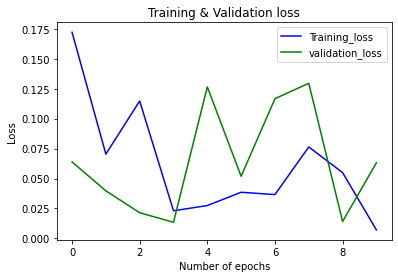

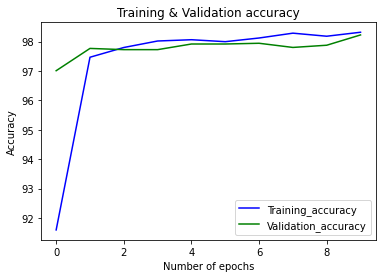

In [12]:
# visualization
plt.plot(range(num_epochs), training_loss, 'b-', label='Training_loss')
plt.plot(range(num_epochs), validation_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(range(num_epochs), training_accuracy, 'b-', label='Training_accuracy')
plt.plot(range(num_epochs), validation_accuracy, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
